# Bài tập về nhà Decision Tree, Random Forest


- Thực hiện các yêu cầu dưới đây với tập dữ liệu Australian credit
- Down dữ liệu tại đường link dưới đây và đặt vào folder /data
 
  https://archive.ics.uci.edu/ml/datasets/Statlog+(Australian+Credit+Approval)
    

In [1]:
# import packages,...

# set random_state = 0
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, ShuffleSplit, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier 

random_state = 0

## 1. Tìm hiểu dữ liệu

In [7]:
'''
- Tìm hiểu cấu trúc data tại trang web UCI
- Down các files, đặt trong folder data/
- Chú ý:
    - Đọc mô tả dữ liệu trong file 'australian.doc'
    - Kiểm tra DecisionTree/RandomForest của Sklearn có hỗ trợ với kiểu dữ liệu được cung cấp không
'''

data_path = r"D:\Hust\FM_Lab\CTAI_ML\ML_homeworks\Hw4\australian.dat"
data = np.genfromtxt(r"D:\Hust\FM_Lab\CTAI_ML\ML_homeworks\Hw4\australian.dat")
df = pd.DataFrame(data=data, columns=[['A'+str(i) for i in range(1,15)]+['Y']])
print(df.head())

X = df.drop(['Y'], axis = 1)
y = df['Y']

encode = ColumnTransformer(
    transformers = [('one_hot_encoder', OneHotEncoder(categories='auto'), [3,4,5,11])],
    remainder = 'passthrough'
)

X = encode.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
print(X_train.shape, X_test.shape)

    A1     A2     A3   A4   A5   A6     A7   A8   A9   A10  A11  A12    A13  \
0  1.0  22.08  11.46  2.0  4.0  4.0  1.585  0.0  0.0   0.0  1.0  2.0  100.0   
1  0.0  22.67   7.00  2.0  8.0  4.0  0.165  0.0  0.0   0.0  0.0  2.0  160.0   
2  0.0  29.58   1.75  1.0  4.0  4.0  1.250  0.0  0.0   0.0  1.0  2.0  280.0   
3  0.0  21.67  11.50  1.0  5.0  3.0  0.000  1.0  1.0  11.0  1.0  2.0    0.0   
4  1.0  20.17   8.17  2.0  6.0  4.0  1.960  1.0  1.0  14.0  0.0  2.0   60.0   

      A14    Y  
0  1213.0  0.0  
1     1.0  0.0  
2     1.0  0.0  
3     1.0  1.0  
4   159.0  1.0  
(552, 38) (138, 38)


C:\Users\Admin\AppData\Local\Temp\ipykernel_2988\2917348907.py:14: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = df.drop(['Y'], axis = 1)


## 2. Decision Tree

### 2.1. Khảo sát các giá trị khác nhau của max_depth

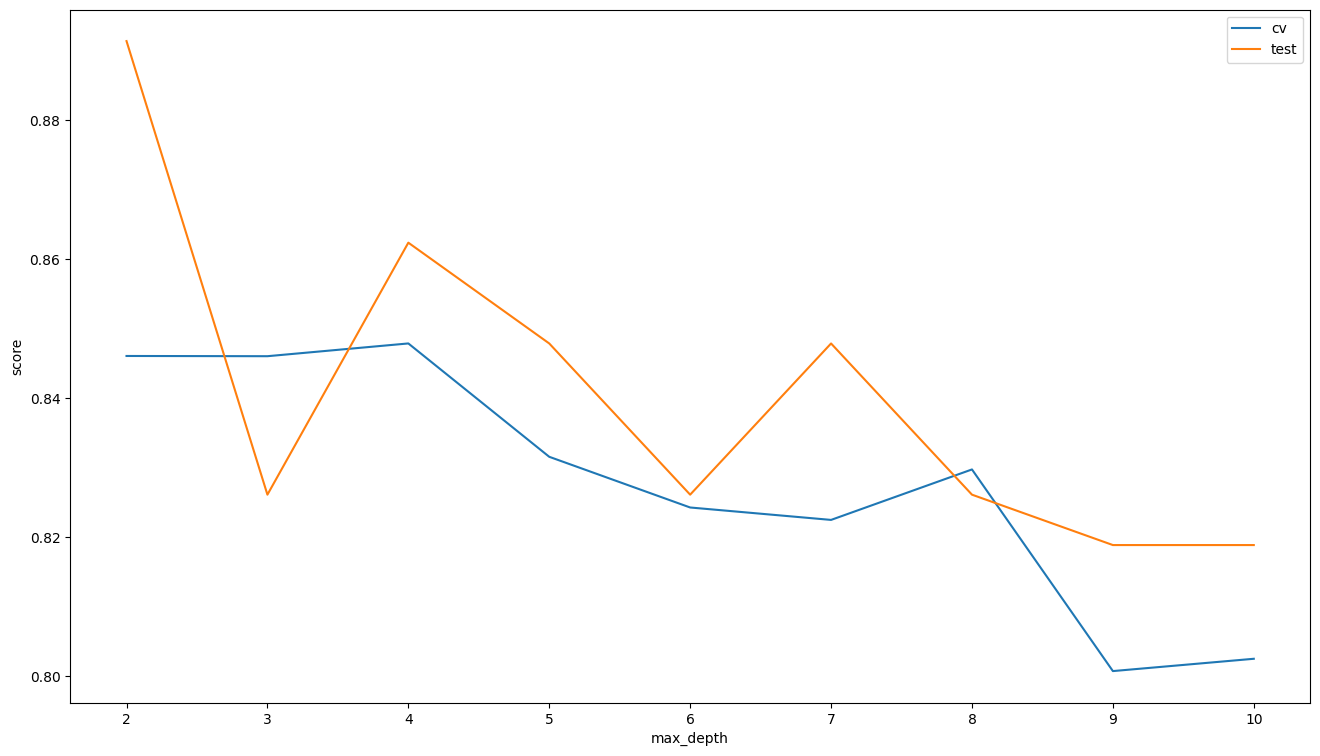

In [8]:
# code
cv_acc, test_acc = [], []
depths = np.arange(2,11)
for depth in depths:
    tree = DecisionTreeClassifier(random_state=random_state, max_depth= depth)

    cv_acc.append(cross_val_score(estimator=tree, X=X_train, y=y_train, cv=5, scoring='accuracy').mean())

    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    test_acc.append(accuracy_score(y_test, y_pred))

plt.figure(figsize=(16,9))
plt.plot(depths, cv_acc, label='cv')
plt.plot(depths, test_acc, label='test')
plt.ylabel('score')
plt.xlabel('max_depth')
plt.legend()
plt.show()

### 2.2. Tìm kiếm siêu tham số

In [9]:
#code
parameter={
    'max_depth': [2, 3, 4, 5, 6, 7],
    'min_samples_split' : np.arange(2,22,2),
    'min_samples_leaf' : np.arange(1,21,2),
    'max_leaf_nodes': (2, 5, 10, 20, 50),
}
grid=GridSearchCV(DecisionTreeClassifier(), parameter, verbose=1, n_jobs=-1)
gridfit=grid.fit(X_train,y_train)
print(gridfit.best_params_)
y_pred = gridfit.predict(X_test)
print(accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 3000 candidates, totalling 15000 fits
{'max_depth': 5, 'max_leaf_nodes': 10, 'min_samples_leaf': np.int64(3), 'min_samples_split': np.int64(20)}
0.8695652173913043


## 3. Random Forest

### 3.1 Khảo sát các giá trị khác nhau của n_estimators

Text(0.5, 1.0, 'Random-Forest: scores vs n_estimators')

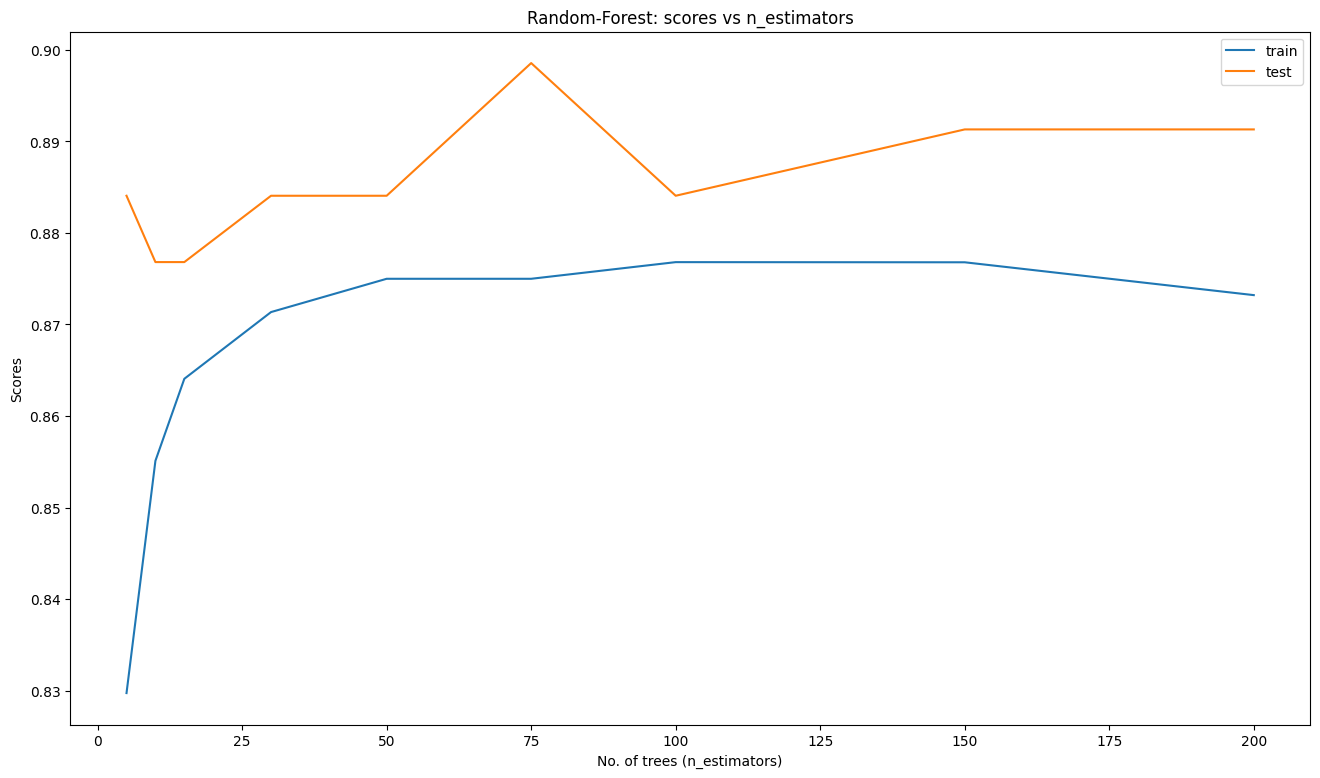

In [10]:
#code
trees = [5, 10, 15, 30, 50, 75, 100, 150, 200]
cv_acc_forest = []
test_acc_forest = []
for tree in trees:
    model = RandomForestClassifier(n_estimators=tree, random_state=random_state, n_jobs=-1)
    cv_acc_forest.append(cross_val_score(estimator=model, X=X_train, y=y_train.squeeze(), cv=5, scoring='accuracy').mean())
    model.fit(X_train, y_train.squeeze())
    y_pred_forest = model.predict(X_test)
    test_acc_forest.append(accuracy_score(y_test, y_pred_forest))

plt.figure(figsize=(16, 9))
plt.plot(trees, cv_acc_forest, label='train')
plt.plot(trees, test_acc_forest, label='test')
plt.legend()
plt.xlabel('No. of trees (n_estimators)')
plt.ylabel('Scores')
plt.title('Random-Forest: scores vs n_estimators')

### 3.2 Tìm kiếm siêu tham số

In [11]:
# code
parameter={
    'max_depth': [2,3,5,7,10, 20],
    'min_samples_leaf': [1,10,30,60],
    'max_features': [1.0,'log2','sqrt',1],
    'n_estimators': [1,2,3,5,10, 20, 50, 100,170]
    }
grid=GridSearchCV(RandomForestClassifier(random_state=random_state), parameter,n_jobs=-1, verbose=1)
gridfit=grid.fit(X_train,y_train.squeeze())
print(gridfit.best_params_)
y_pred = gridfit.predict(X_test)
print(accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
{'max_depth': 10, 'max_features': 1.0, 'min_samples_leaf': 1, 'n_estimators': 100}
0.8840579710144928
